In [1]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [2]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [3]:
dir = 'annoted_sustainability_reports/Healthcare/'

In [4]:
x_label = ["EliLilly", "UnitedHealthGroup", "Merck", "BristolMyersSquibb", "Danaher", "johnsonandjohnson", 
            "Pfizer", "Abbott", "ThermoFisherScientifiic", "Amgen"]

### Extracting Sentences: Refined Version

In [5]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [6]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4]) 
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [7]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [8]:
def make_text(words):
    """Return textstring output of getText("words").

    Word items are sorted for reading sequence left to right,
    top to bottom.
    """
    line_dict = {}  # key: vertical coordinate, value: list of words
    words.sort(key=lambda w: w[0])  # sort by horizontal coordinate
    for w in words:  # fill the line dictionary
        y1 = round(w[3], 0)  # bottom of a word: don't be too picky!
        word = w[4]  # the text of the word
        line = line_dict.get(y1, [])  # read current line content
        line.append(word)  # append new word
        line_dict[y1] = line  # write back to dict
    lines = list(line_dict.items())
    lines.sort()  # sort vertically
    return "\n".join([" ".join(line[1]) for line in lines])

In [9]:
import pdftotext

In [10]:
# Get ALL SENTENCES using the pdftotext package:

all_result_refined = []
all_comp_refined = []

# running all the files in the industry folder
for file in os.listdir(dir): 

    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)

    with open(f, "rb") as output:
        pdf = pdftotext.PDF(output)

        # Read all the text into one string
        pdftotext_text = " ".join(pdf)
        
    for sent in tokenize.sent_tokenize(pdftotext_text):
        for within_sent in sent.split('\n\n'):
            all_result_refined.append(within_sent)
            all_comp_refined.append(comp_lab[0])


annoted_sustainability_reports/Healthcare/EliLilly_2021_Environmental_ESG_report.pdf
['EliLilly']
annoted_sustainability_reports/Healthcare/UnitedHealthGroup_2021-sustainability-report.pdf
['UnitedHealthGroup']
annoted_sustainability_reports/Healthcare/Merck_2021_ESG_report.pdf
['Merck']
annoted_sustainability_reports/Healthcare/BristolMyersSquibb_2020_ESG.pdf
['BristolMyersSquibb']
annoted_sustainability_reports/Healthcare/Danaher_2021_sustainability_report.pdf
['Danaher']
annoted_sustainability_reports/Healthcare/johnsonandjohnson_2021-health-for-humanity-report-pdf.pdf
['johnsonandjohnson']
annoted_sustainability_reports/Healthcare/Pfizer_NetZero_2022_update.pdf
['Pfizer']
annoted_sustainability_reports/Healthcare/Abbott_2021_sustainability_report.pdf
['Abbott']
annoted_sustainability_reports/Healthcare/ThermoFisherScientifiic_2021_CSR_report.pdf
['ThermoFisherScientifiic']
annoted_sustainability_reports/Healthcare/Amgen_2021_ESG_report.pdf
['Amgen']


In [11]:
len(all_result_refined)

36123

In [12]:
for i in range(len(all_result_refined)):
    all_result_refined[i] = re.sub("\n", " ", all_result_refined[i])
    all_result_refined[i] = re.sub("\x0c", "", all_result_refined[i])
    all_result_refined[i] = re.sub("\x07", "", all_result_refined[i])

In [13]:
from random import sample

In [14]:
sample(all_result_refined, 10)

['These initiatives include Merck for Mothers, the MECTIZAN® Donation Program and our company’s Medical Outreach Program (MMOP).',
 'Commercial and Other Buildings Region Total',
 'In 2021, we launched a localized My Health Can’t Wait pilot program, focusing on underserved communities in Chicago, informed by research that indicates that Black and Hispanic adults deferred care at higher rates throughout the pandemic, reinforcing the inequities facing communities of color in the region.',
 '2,952',
 '30',
 'for decades, despite being notoriously difficult',
 'Metric',
 'In addition, Danaher in certain circumstances employs innovative, targeted approaches to address the needs of developing countries, including collaborative partnerships with global organizations; please refer to this Report’s Diagnostics Innovation section for examples of how we advance access to healthcare.',
 'Europe, Middle East & Africa',
 'In 2021, Johnson & Johnson exceeded $2 billion procurement spend with Tier 1 d

In [15]:
df = pd.DataFrame([all_result_refined, all_comp_refined]).transpose()

In [16]:
for i in df[df[1] == 'Merck'][0]:
    print(i)
    print()

Environmental, Social & Governance (ESG) Progress Report 2020/2021

 Contents

2

Overview

3

A letter from our CEO

5

2020/2021 Highlights

6

Our company

7

Our ESG approach

10

Access to health

16

Employees

19

Environmental sustainability

23

Awards and recognition

24

References

25 GRI/SASB disclosures 26

General disclosures

50

Economic

83

Environmental

118

Social

171 Indices 171

Global Reporting Initiative (GRI)

179

Sustainability Accounting Standards Board (SASB)

182

UN Global Compact

183

UN Sustainable Development Goals (SDGs)

185

Culture of Health for Business (COH4B)

187

World Economic Forum (WEF) Stakeholder Capitalism Metrics

About this report This is the Environmental, Social & Governance (ESG) Progress Report 2020/2021 of Merck & Co., Inc., Kenilworth, N.J., U.S.A., which is known as MSD outside the United States (U.S.) and Canada.

Information on documents filed with the Securities and Exchange Commission (SEC), such as our Form 10-K and Pro

In [15]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text()
        all_result.append(all_text)
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words('words', sort = True)
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
    print('>>>>RELEVANT<<<<')
    print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
#     for i in all_result:
#         i = re.sub("\xa0", " ", i)
#         i = re.sub("\t", " ", i)
#         i = re.sub("\r", " ", i)
#         i = re.sub("\n", " ", i)
#         i = re.sub(" +", " ", i)
# #         i = i.strip()
#         final_all += tokenize.sent_tokenize(i)
#         final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

    print('>>>>ALL_REFINED<<<<')
    print(all_result_refined)
    
            


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Document('annoted_sustainability_reports/Healthcare/Merck_2021_ESG_report.pdf')
>>>>RELEVANT<<<<
['In 2021, 9.6% of our purchased electricity came from renewable sources.', 'A large portion of this renewable electricity is delivered through our utility providers to our sites in Alcobendas, Spain; Kinsale, Ireland; and Bracknell, UK.', 'From 2012 to 2020, we achieved a 26% reduction in absolute emissions.', 'In 2021, we achieved a 9% absolute emissions reduction versus 2020.', 'This reduction was partially driven by energy e�ciency improvements and an increase in the use of renewable electricity including the startup of our solar array in Kinsale.', 'In 2021, we reduced our energy consumption by 2.9%,', 'In 2021, 9.6% of our purchased electricity was secured from renewable sources.', 'We have reduced GHG emissions at key facilities by leveraging solar energy.', 'These projects include: Kinsale – In July, 2021, Lilly started up a 20-acre solar array in Kinsale, Ireland consisting of over

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Relevant & All Sentences into a DataFrame

In [16]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,"In 2021, 9.6% of our purchased electricity cam...",EliLilly
1,A large portion of this renewable electricity ...,EliLilly
2,"From 2012 to 2020, we achieved a 26% reduction...",EliLilly
3,"In 2021, we achieved a 9% absolute emissions r...",EliLilly
4,This reduction was partially driven by energy ...,EliLilly


In [17]:
all_text_df = pd.DataFrame([all_result_refined, all_comp_refined]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,"7/7/22, 10:29 AM",EliLilly
1,Environmental | 2021 ESG Report | Eli Lilly an...,EliLilly
2,Menu,EliLilly
3,"Our Environmental Approach Our purpose, to mak...",EliLilly
4,Making medicines requires the use of valuable ...,EliLilly


### Relevant Sentences Statistics

In [18]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
EliLilly,16
Merck,13
BristolMyersSquibb,5
Danaher,2
johnsonandjohnson,14
Pfizer,1
Abbott,10
ThermoFisherScientifiic,7
Amgen,4


In [19]:
# Old Version
# rel_text_df.groupby('company_label', sort = False).count()

In [20]:
rel_text_df[rel_text_df.duplicated()]

,relevant_sentences,company_label


In [21]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
EliLilly,263
UnitedHealthGroup,2550
Merck,7034
BristolMyersSquibb,3488
Danaher,3222
johnsonandjohnson,5976
Pfizer,438
Abbott,8241
ThermoFisherScientifiic,2554


In [22]:
# Old Version
# all_text_df.groupby('company_label', sort = False).count()

### Getting Sentence Statistics 

In [23]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [24]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
EliLilly,263,16.0,6.083650
UnitedHealthGroup,2550,0.0,0.000000
Merck,7034,13.0,0.184817
BristolMyersSquibb,3488,5.0,0.143349
Danaher,3222,2.0,0.062073
johnsonandjohnson,5976,14.0,0.234270
Pfizer,438,1.0,0.228311
Abbott,8241,10.0,0.121344
ThermoFisherScientifiic,2554,7.0,0.274080


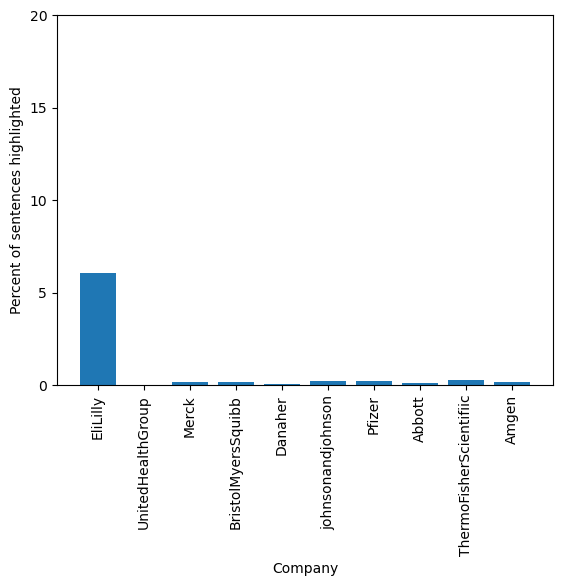

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 25, 5))
plt.show()

In [26]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    9.000000
mean     0.833511
std      1.969846
min      0.062073
25%      0.143349
50%      0.184817
75%      0.234270
max      6.083650
dtype: float64

### Exporting and Saving Files 

In [28]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

HC_reltext = rel_text_df
HC_alltext = all_text_df
HC_stat = final_text_stat

%store HC_reltext
%store HC_alltext
%store HC_stat

Stored 'HC_reltext' (DataFrame)
Stored 'HC_alltext' (DataFrame)
Stored 'HC_stat' (DataFrame)
